# SHAP-Style Plots  Documentation

This notebook is designed to demonstrate how to use `pymint` to plot [SHAP-style](https://github.com/slundberg/shap) plots within MintPy. For more information on dataset and initializing `InterpretToolkit`, see the permutatation importance notebook.

In [1]:
import sys, os 
current_dir = os.getcwd()
path = os.path.dirname(current_dir)
sys.path.append(path)
import numpy as np
import xarray as xr
import pandas as pd
import shap

In [2]:
import pymint
from pymint.common.utils import shap_values_to_importance, coefficients_to_importance
from pymint.common.multiprocessing_utils import run_parallel
import plotting_config 

### Loading the training data and pre-fit models 


In [3]:
estimators = pymint.load_models()
X,y = pymint.load_data()

In [4]:
X_subset = shap.sample(X, 50, random_state=22)
explainer = pymint.InterpretToolkit(estimators[0], X=X_subset,)

## Compute the SHAP Values 

When computing SHAP values, the user has a couple options (passed in as ``shap_kwargs``). First, we need to declare the ``masker``. In this example, we are using a built-in method from the SHAP python package (see https://shap.readthedocs.io/en/latest/generated/shap.maskers.Partition.html#shap.maskers.Partition) for details on maskers). We could also pass in a background dataset rather a masker (e.g., masker = shap.sample(X, 100).reset_index(drop=True)). Second, we can declare the SHAP algorithm we want to use. By default, we set ``algorithm = "auto"`` and the SHAP package will determine the best algorithm. If we use the Partition masker, I've found that it will default to the ``Exact`` and otherwise it will try to use ``Permutation`` (note there are other options, but for different model types).

In [5]:
results = explainer.shap(shap_kwargs={'masker' : 
                                      shap.maskers.Partition(X, max_samples=100, clustering="correlation"), 
                                     'algorithm' : 'auto'})

algorithm auto


Exact explainer: 51it [00:27,  1.28it/s]                                                                                                                                                                                                                                                                              


## Summary Plot

Once we compute the SHAP values for a large number of examples, we can evaluate different patterns. For example, in the plot below, SHAP values are ranked by their absolute sum. Additionally, the SHAP values are color-coded by their normalized magnitude where red indicates a higher predictor value while blue indicates a lower predictor value. In this case, surface temperature ($T_{sfc}$) had the largest absolute sum and lower values increases the probability of freezing road surface temperatures. 



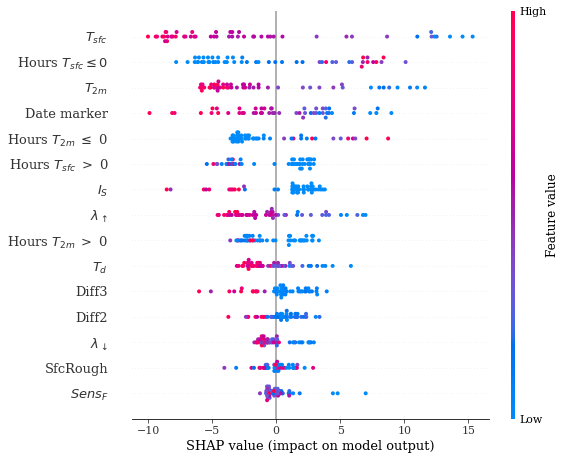

In [6]:
shap_values, bias = results['Random Forest']
explainer.plot_shap(
                    plot_type = 'summary',
                    shap_values=shap_values,
                    display_feature_names=plotting_config.display_feature_names,
)                           

Instead of this plot, we can evaluate the SHAP-based ranking with the bar-style plot used in PyMint. 

(<Figure size 900x750 with 3 Axes>, <AxesSubplot:>)

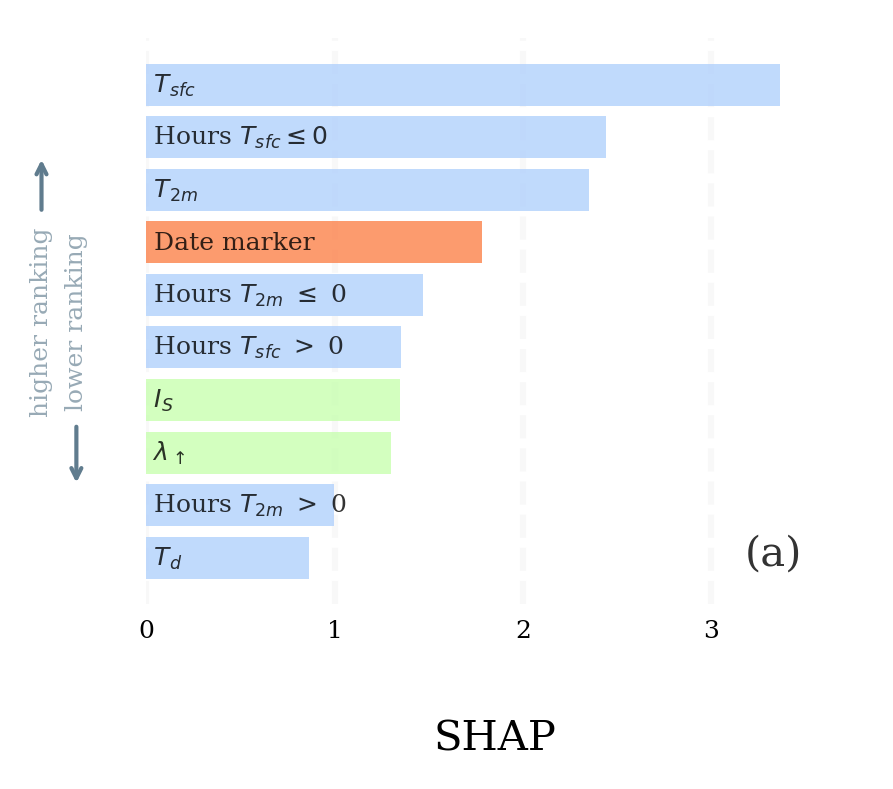

In [9]:
data = shap_values_to_importance(shap_values, estimator_name='Random Forest', feature_names=X.columns)
explainer.plot_importance(data=data,
                          panels = [('shap', 'Random Forest')],
                          display_feature_names=plotting_config.display_feature_names,
                          feature_colors=plotting_config.color_dict,
                          method='shap')

### Dependence Plot

SHAP values can also be displayed similar to ALE/PD curve where the values are presented as a function of the predictor value. For this plots, we can also include `histdata`, which is a combination of `X` and `y`. For classification problems, the user can provide the name of the target variable and the background histogram will be color-coded for the different classes. Lastly, each dot is color coded by the value of the feature that approximately interacts with the feature being plotted. 


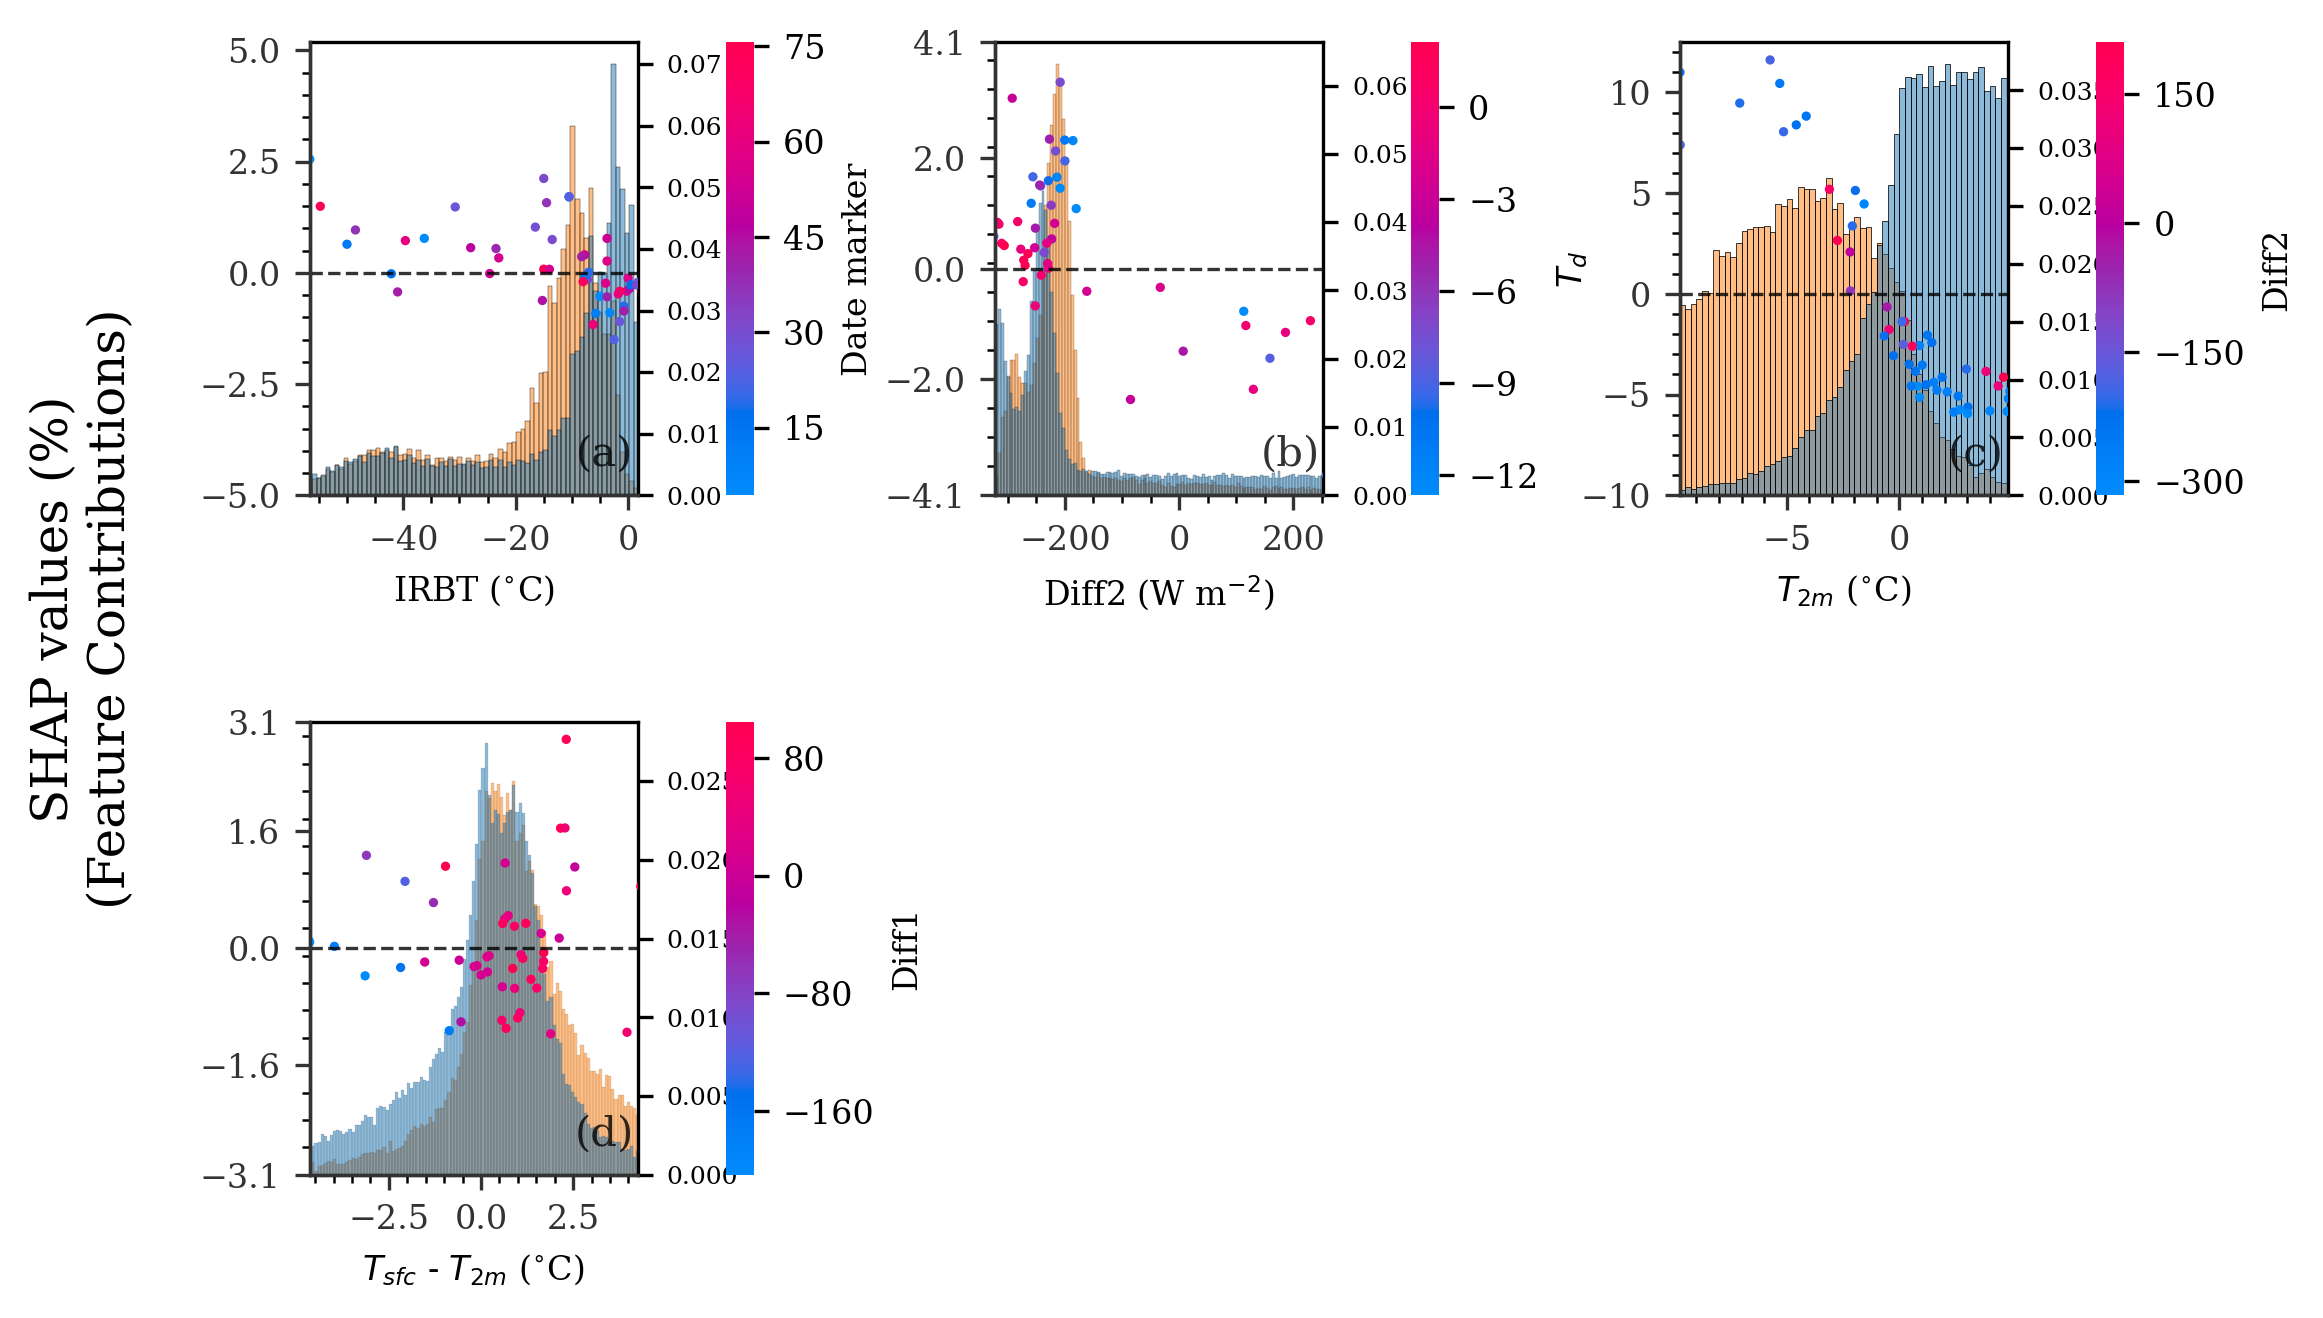

In [11]:
features = ['sat_irbt', 'd_rad_d', 'temp2m', 'hrrr_dT']

histdata=X.copy()
histdata['target'] = y

explainer.plot_shap(features=features,
                    plot_type = 'dependence',
                    shap_values=shap_values,
                    display_feature_names=plotting_config.display_feature_names,
                    display_units = plotting_config.display_units,
                    histdata=histdata,
                    target='target',
                    interaction_index='auto'
)

## No color-coding of dots 

Set `interaction_index=None` to remove the color-coding. 

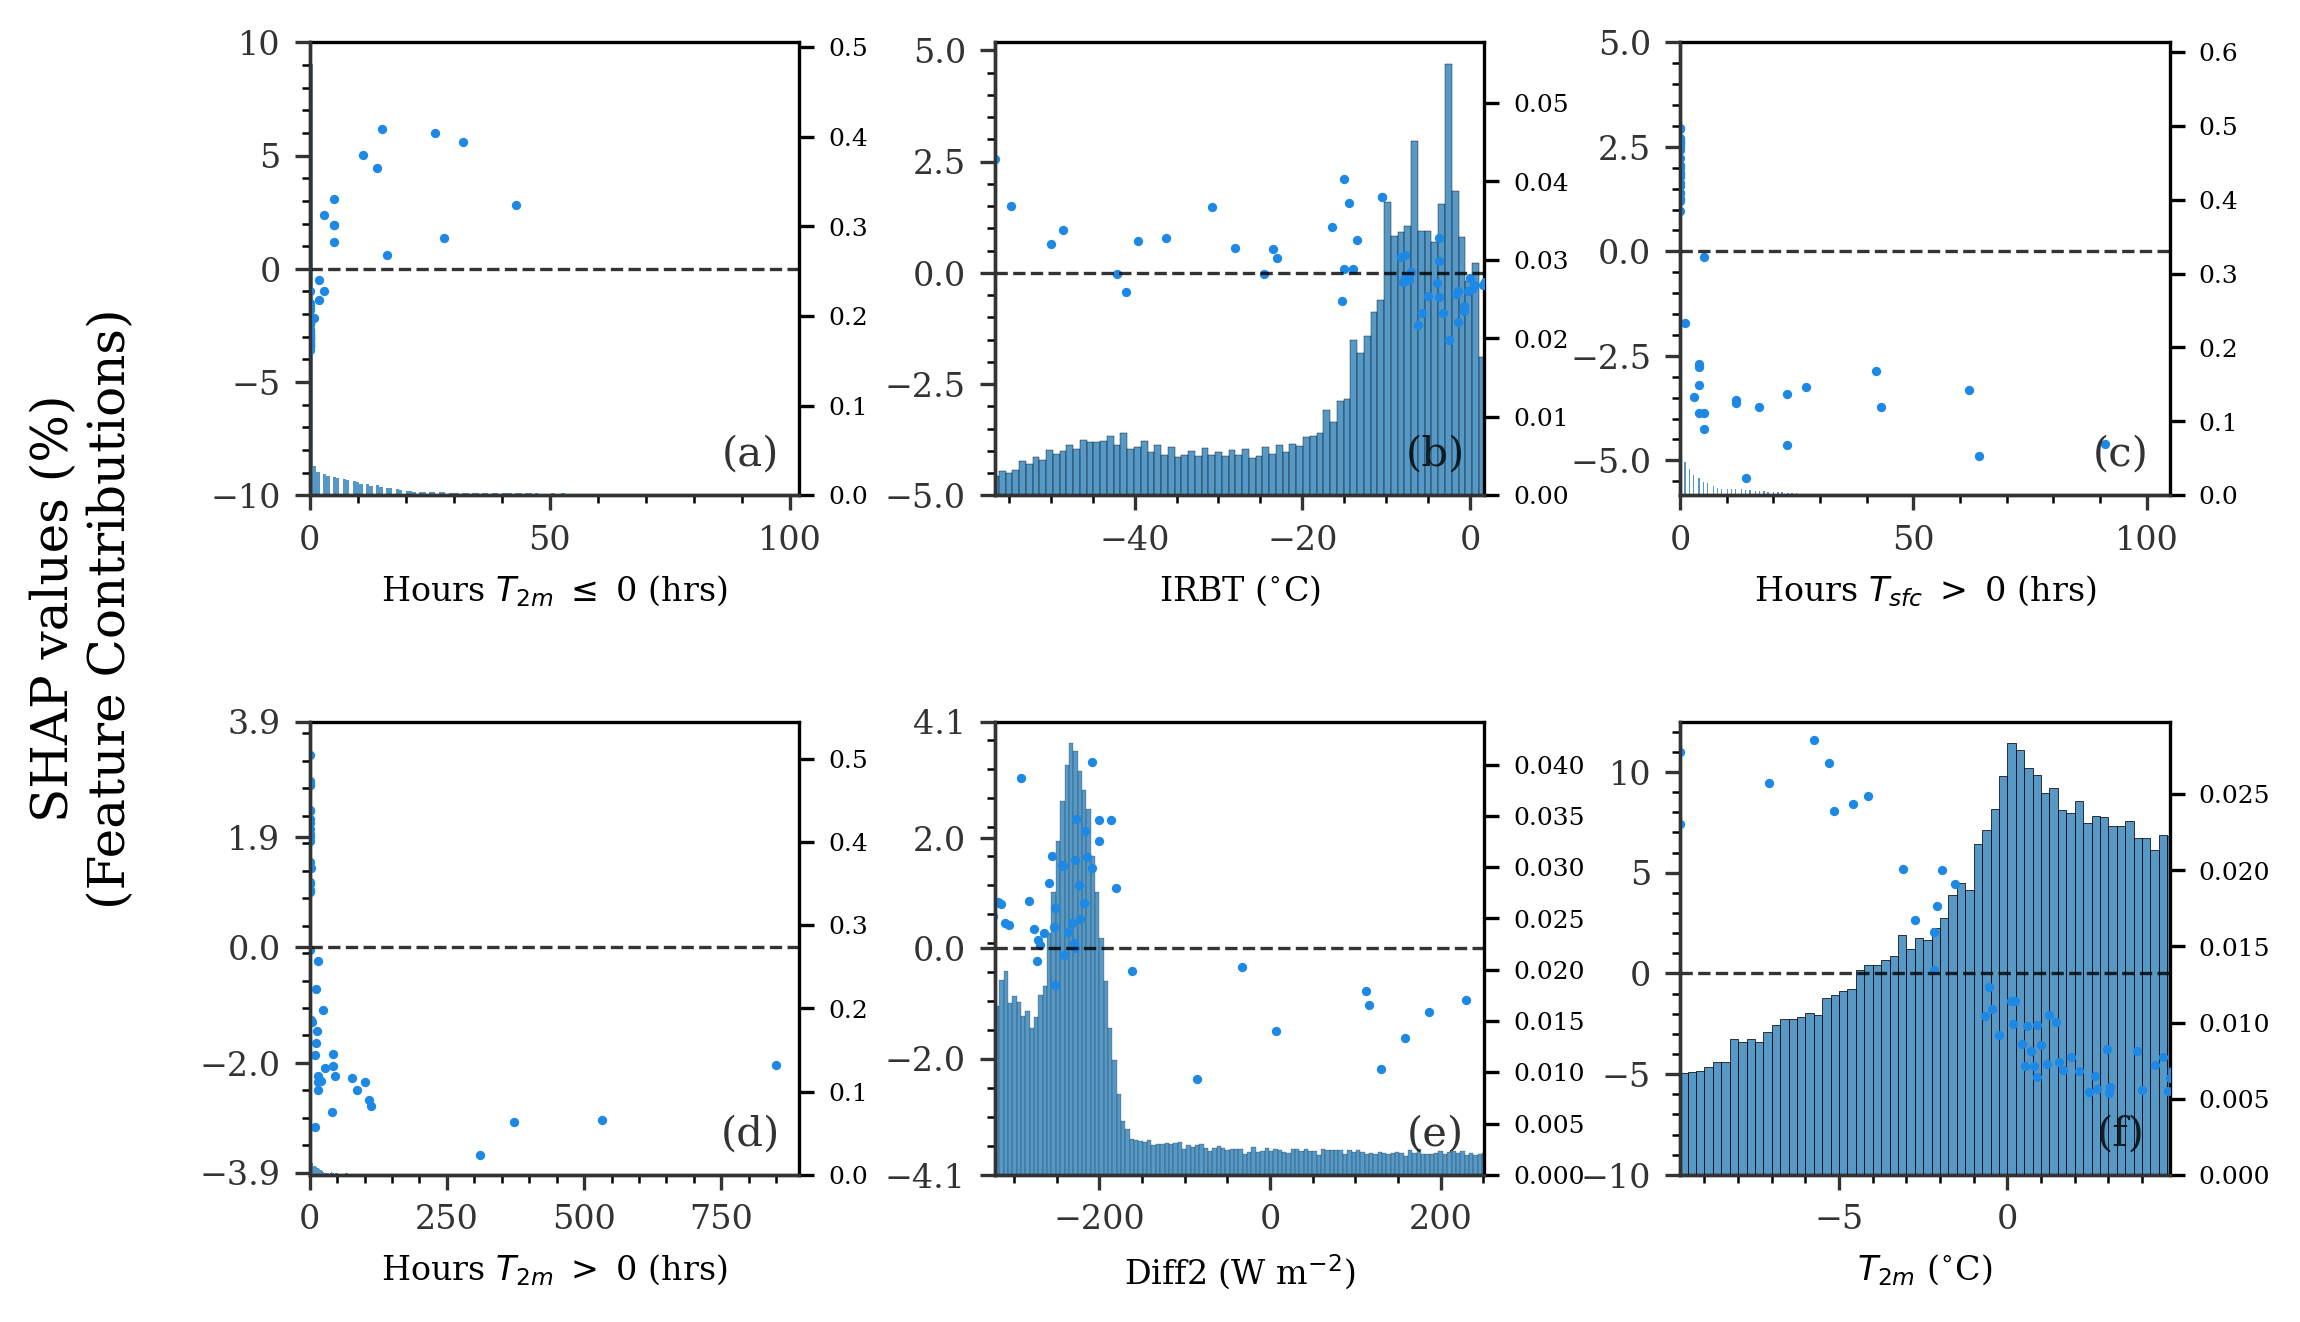

In [12]:
features = ['tmp2m_hrs_bl_frez', 'sat_irbt', 'sfcT_hrs_ab_frez', 'tmp2m_hrs_ab_frez', 'd_rad_d', 'temp2m']

explainer.plot_shap(features=features,
                    plot_type = 'dependence',
                    shap_values=shap_values,
                    display_feature_names=plotting_config.display_feature_names,
                    display_units = plotting_config.display_units,
                    histdata=histdata,
                    interaction_index=None,
)

## SHAP for Regression

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor

In [ ]:
data = fetch_california_housing()
X = data['data']
y = data['target']
feature_names = data['feature_names']
model= RandomForestRegressor()
model.fit(X,y)

In [ ]:
X_subset = shap.sample(X, 100, random_state=42)
explainer = pymint.InterpretToolkit(('Random Forest', model),X=X_subset, feature_names=feature_names)

In [ ]:
background_dataset = shap.sample(X, 100)
results = explainer.shap(background_dataset=background_dataset)
shap_values, bias = results['Random Forest']
explainer.plot_shap(
                    plot_type = 'summary',
                    shap_values=shap_values,
                    display_feature_names=plotting_config.display_feature_names,
)                           